 # Notebook 16: Topic-Bias Correlation

 ## Purpose
 - Correlate article topics with bias dimensions
 - Identify which topics have highest bias
 - Analyze topic-specific bias patterns
 - Compare bias across media sources
 - Track topic evolution over time
 - Statistical significance testing

 ## Inputs
 - `data/processed/articles_with_events_sample_30000.csv`
 - `data/processed/keyword_features_sample_30000.parquet`
 - `data/processed/implicit_bias_features_sample_30000.parquet`

 ## Outputs
 - `data/processed/topic_bias_correlation_sample_30000.csv`
 - `data/processed/topic_insights_sample_30000.json`

In [ ]:
from scipy.stats import f_oneway
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr
import json
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported")

Libraries imported


In [ ]:
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

# Input files
ARTICLES_FILE = PROCESSED_DIR / 'articles_with_events.csv'
KEYWORD_FILE = PROCESSED_DIR / 'keyword_features.parquet'
IMPLICIT_FILE = PROCESSED_DIR / 'implicit_bias_features.parquet'

# Output files
CORRELATION_FILE = PROCESSED_DIR / 'topic_bias_correlation.csv'
INSIGHTS_FILE = PROCESSED_DIR / 'topic_insights.json'

print("Paths configured")

Paths configured


 ## 1. Load Data and Topic Classifications

In [ ]:
print("Loading data...")

# Load articles
df = pd.read_csv(ARTICLES_FILE, parse_dates=['publication_date', 'published_date_parsed'])
print(f"Articles: {len(df):,} rows")

# Load features
df_keyword = pd.read_parquet(KEYWORD_FILE)
df_implicit = pd.read_parquet(IMPLICIT_FILE)

print(f"Keyword features: {len(df_keyword):,} rows")
print(f"Implicit bias features: {len(df_implicit):,} rows")

Loading data...
Articles: 29,329 rows
Keyword features: 29,329 rows
Implicit bias features: 29,329 rows


In [ ]:
# Merge features
print("\nMerging features...")
df = df.merge(df_keyword, on='url', how='left')
df = df.merge(df_implicit, on='url', how='left')

print(f"Merged dataset: {len(df):,} rows, {len(df.columns)} columns")

# Get text column
text_col = 'article_text' if 'article_text' in df.columns else 'text'
df['text'] = df[text_col].fillna('')


Merging features...
Merged dataset: 29,329 rows, 267 columns


 ## 2. Classify Articles by Topic

In [ ]:
print("\n=== TOPIC CLASSIFICATION ===")

# Define topic keywords (in real scenario, this could be from an LDA model or classifier)
TOPIC_KEYWORDS = {
    'politics': [
        'election', 'government', 'minister', 'parliament', 'bjp', 'congress',
        'party', 'vote', 'campaign', 'political', 'modi', 'rahul'
    ],
    'religion': [
        'hindu', 'muslim', 'christian', 'temple', 'mosque', 'church',
        'religious', 'faith', 'worship', 'prayer', 'religion', 'communal'
    ],
    'crime': [
        'murder', 'rape', 'theft', 'crime', 'police', 'arrest', 'accused',
        'victim', 'criminal', 'violence', 'assault', 'robbery'
    ],
    'economy': [
        'economy', 'market', 'business', 'trade', 'gdp', 'inflation',
        'stock', 'finance', 'bank', 'investment', 'rupee', 'economic'
    ],
    'education': [
        'school', 'university', 'student', 'education', 'exam', 'college',
        'teacher', 'learning', 'academic', 'study', 'degree', 'campus'
    ],
    'health': [
        'health', 'hospital', 'doctor', 'medical', 'patient', 'disease',
        'covid', 'medicine', 'treatment', 'healthcare', 'clinic', 'vaccine'
    ],
    'sports': [
        'cricket', 'football', 'sport', 'match', 'player', 'team',
        'tournament', 'game', 'win', 'champion', 'coach', 'stadium'
    ],
    'entertainment': [
        'film', 'movie', 'actor', 'bollywood', 'music', 'celebrity',
        'entertainment', 'show', 'star', 'singer', 'director', 'cinema'
    ],
    'social_issues': [
        'women', 'dalit', 'caste', 'discrimination', 'reservation', 'equality',
        'rights', 'protest', 'movement', 'justice', 'activist', 'social'
    ],
    'environment': [
        'environment', 'pollution', 'climate', 'forest', 'wildlife', 'water',
        'air quality', 'green', 'nature', 'conservation', 'ecology', 'carbon'
    ]
}


def classify_topic(text):
    """Classify article topic based on keyword matching"""
    if not text:
        return 'other'

    text_lower = text.lower()
    topic_scores = {}

    for topic, keywords in TOPIC_KEYWORDS.items():
        score = sum(1 for keyword in keywords if keyword in text_lower)
        topic_scores[topic] = score

    # Return topic with highest score, or 'other' if no match
    if max(topic_scores.values()) > 0:
        return max(topic_scores, key=topic_scores.get)
    return 'other'


print("\nClassifying articles by topic...")
df['topic'] = df['text'].apply(classify_topic)

print("\nTopic Distribution:")
topic_counts = df['topic'].value_counts()
print(topic_counts)


=== TOPIC CLASSIFICATION ===

Classifying articles by topic...

Topic Distribution:
topic
politics         9297
sports           6968
economy          3779
crime            2808
entertainment    2006
education        1517
health           1276
religion          554
social_issues     467
environment       372
other             285
Name: count, dtype: int64


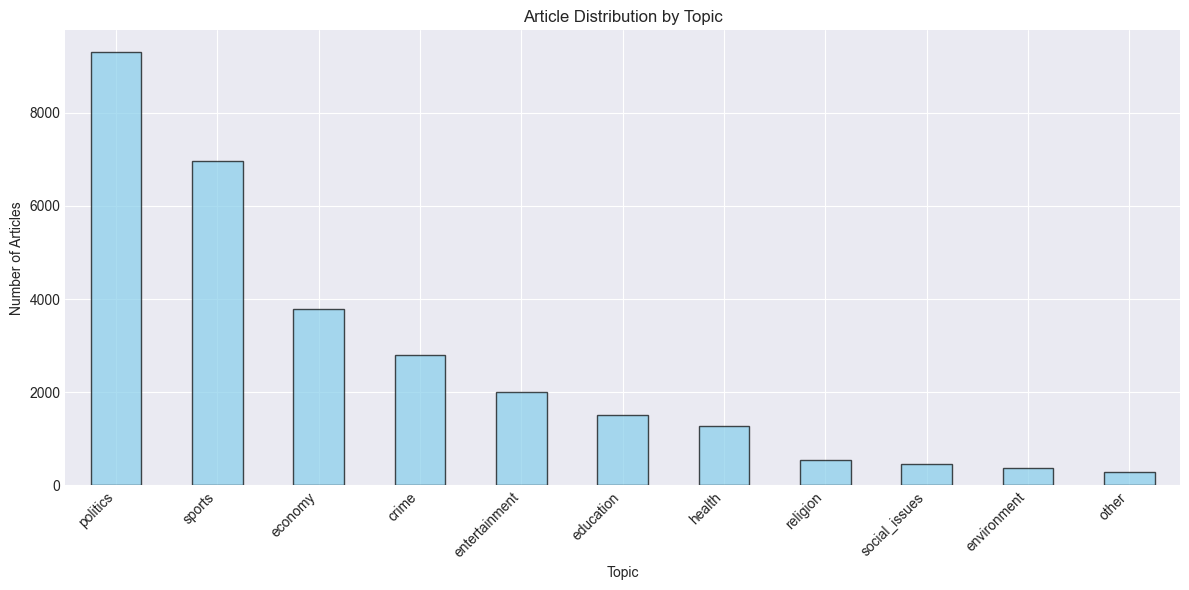

In [ ]:
# Visualize topic distribution
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Article Distribution by Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Key Insights: Article Distribution by Topic

1) Coverage is heavily skewed toward hard news and sports, with politics and sports together accounting for the majority of articles, followed by economy and crime as secondary focuses.

2) Social and public-interest topics are relatively underrepresented, with education, health, religion, social_issues, environment, and other each making up only a small share of total coverage.

 ## 3. Calculate Bias Scores by Dimension

In [ ]:
print("\n=== CALCULATING BIAS SCORES ===")

# Identify bias-related features
religious_features = [c for c in df.columns if 'muslim' in c.lower() or 'hindu' in c.lower() or 'christian' in c.lower()]
gender_features = [c for c in df.columns if 'women' in c.lower() or 'gender' in c.lower() or 'female' in c.lower()]
caste_features = [c for c in df.columns if 'dalit' in c.lower() or 'caste' in c.lower() or 'sc' in c.lower()]
political_features = [c for c in df.columns if 'bjp' in c.lower() or 'congress' in c.lower() or 'political' in c.lower()]

# Helper: sum only numeric columns among a candidate list


def _sum_numeric_columns(df_in, cols):
    """Safely sum only numeric columns among the given list."""
    numeric_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df_in[c])]
    if not numeric_cols:
        return pd.Series(0, index=df_in.index)
    return df_in[numeric_cols].sum(axis=1)


# Calculate composite bias scores (numeric-only sums to avoid string concatenation)
if religious_features:
    df['religious_bias_score'] = _sum_numeric_columns(df, religious_features)
else:
    df['religious_bias_score'] = 0

if gender_features:
    df['gender_bias_score'] = _sum_numeric_columns(df, gender_features)
else:
    df['gender_bias_score'] = 0

if caste_features:
    df['caste_bias_score'] = _sum_numeric_columns(df, caste_features)
else:
    df['caste_bias_score'] = 0

if political_features:
    df['political_bias_score'] = _sum_numeric_columns(df, political_features)
else:
    df['political_bias_score'] = 0

df['total_bias_score'] = (
    df['religious_bias_score']
    + df['gender_bias_score']
    + df['caste_bias_score']
    + df['political_bias_score']
)

print(f"Calculated bias scores across 4 dimensions")
print(f"  - Articles with bias: {(df['total_bias_score'] > 0).sum():,}")


=== CALCULATING BIAS SCORES ===
Calculated bias scores across 4 dimensions
  - Articles with bias: 17,983


 ## 4. Bias by Topic Analysis

In [ ]:
print("\n=== BIAS BY TOPIC ANALYSIS ===")

# Aggregate bias scores by topic
bias_by_topic = df.groupby('topic').agg({
    'religious_bias_score': ['mean', 'median', 'sum', 'count'],
    'gender_bias_score': ['mean', 'median', 'sum'],
    'caste_bias_score': ['mean', 'median', 'sum'],
    'political_bias_score': ['mean', 'median', 'sum'],
    'total_bias_score': ['mean', 'median', 'sum']
}).round(3)

print("\n=== MEAN BIAS SCORES BY TOPIC ===")
print(bias_by_topic)


=== BIAS BY TOPIC ANALYSIS ===

=== MEAN BIAS SCORES BY TOPIC ===
              religious_bias_score                        gender_bias_score  \
                              mean median       sum count              mean   
topic                                                                         
crime                        0.320    0.0   899.000  2808            20.873   
economy                      0.117    0.0   441.500  3779             3.092   
education                    0.246    0.0   372.467  1517            10.374   
entertainment                0.140    0.0   281.500  2006            12.005   
environment                  0.094    0.0    35.000   372             3.358   
health                       0.143    0.0   183.000  1276            11.494   
other                        0.028    0.0     8.000   285             4.340   
politics                     0.442    0.0  4113.758  9297             6.311   
religion                     4.976    3.0  2756.500   554       

In [ ]:
# Identify highest bias topics
print("\n=== TOPICS WITH HIGHEST BIAS ===\n")

bias_types = ['religious_bias_score', 'gender_bias_score', 'caste_bias_score',
              'political_bias_score', 'total_bias_score']

for bias_type in bias_types:
    topic_means = df.groupby('topic')[bias_type].mean().sort_values(ascending=False)
    print(f"{bias_type.upper().replace('_', ' ')}:")
    for i, (topic, score) in enumerate(topic_means.head(5).items(), 1):
        print(f"  {i}. {topic:20s}: {score:.3f}")
    print()


=== TOPICS WITH HIGHEST BIAS ===

RELIGIOUS BIAS SCORE:
  1. religion            : 4.976
  2. social_issues       : 0.727
  3. politics            : 0.442
  4. crime               : 0.320
  5. education           : 0.246

GENDER BIAS SCORE:
  1. crime               : 20.873
  2. social_issues       : 18.151
  3. entertainment       : 12.005
  4. health              : 11.494
  5. religion            : 11.409

CASTE BIAS SCORE:
  1. social_issues       : 4.532
  2. politics            : 0.765
  3. religion            : 0.758
  4. education           : 0.646
  5. crime               : 0.306

POLITICAL BIAS SCORE:
  1. politics            : 20.597
  2. religion            : 5.460
  3. social_issues       : 5.352
  4. sports              : 4.576
  5. crime               : 3.182

TOTAL BIAS SCORE:
  1. social_issues       : 28.761
  2. politics            : 28.116
  3. crime               : 24.682
  4. religion            : 22.604
  5. entertainment       : 14.801



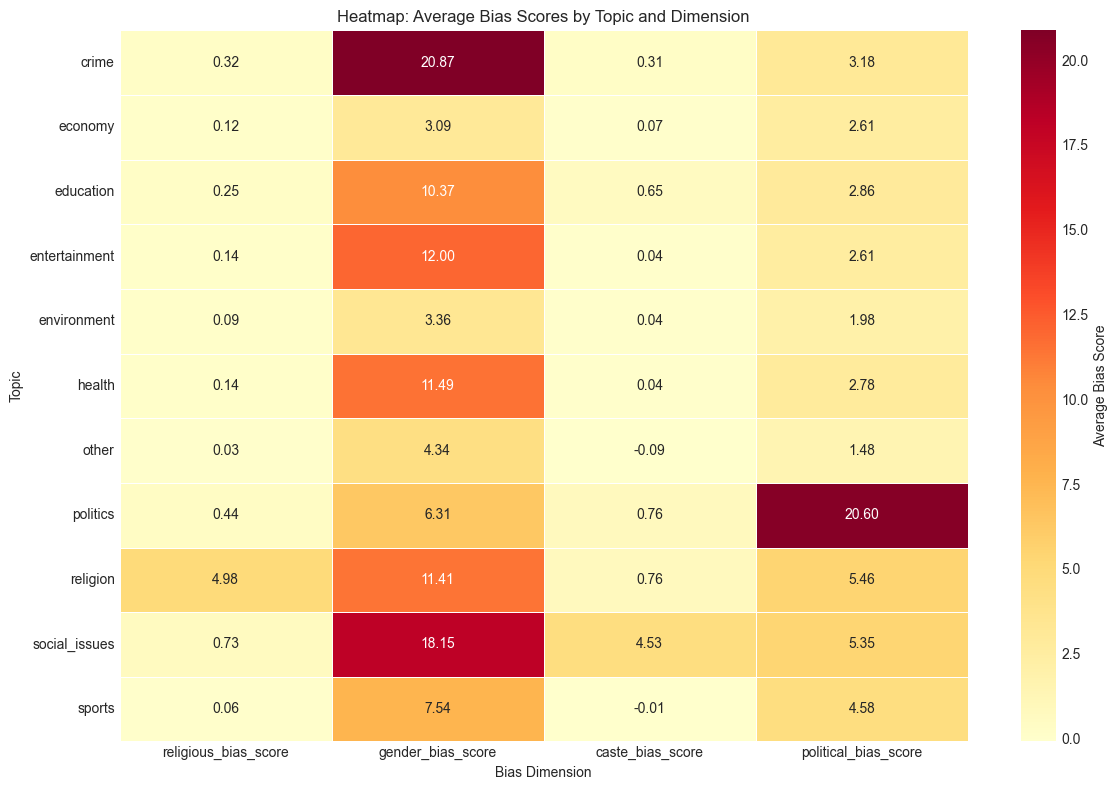

In [ ]:
# Create heatmap of bias by topic
bias_heatmap_data = df.groupby('topic')[
    ['religious_bias_score', 'gender_bias_score', 'caste_bias_score', 'political_bias_score']
].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(bias_heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'Average Bias Score'})
plt.xlabel('Bias Dimension')
plt.ylabel('Topic')
plt.title('Heatmap: Average Bias Scores by Topic and Dimension')
plt.tight_layout()
plt.show()

#### Key insights: Heatmap of average bias scores by topic and dimension

1) Gender bias is the most pronounced overall, peaking in coverage of crime and social issues, and is also relatively high for health, entertainment, education, religion, and sports topics.

2) Political bias is strongly concentrated in political news, with secondary but noticeable bias in religion, social issues, and sports, while religious and caste biases remain low for most topics except for higher religious and caste bias in religion/social issues.

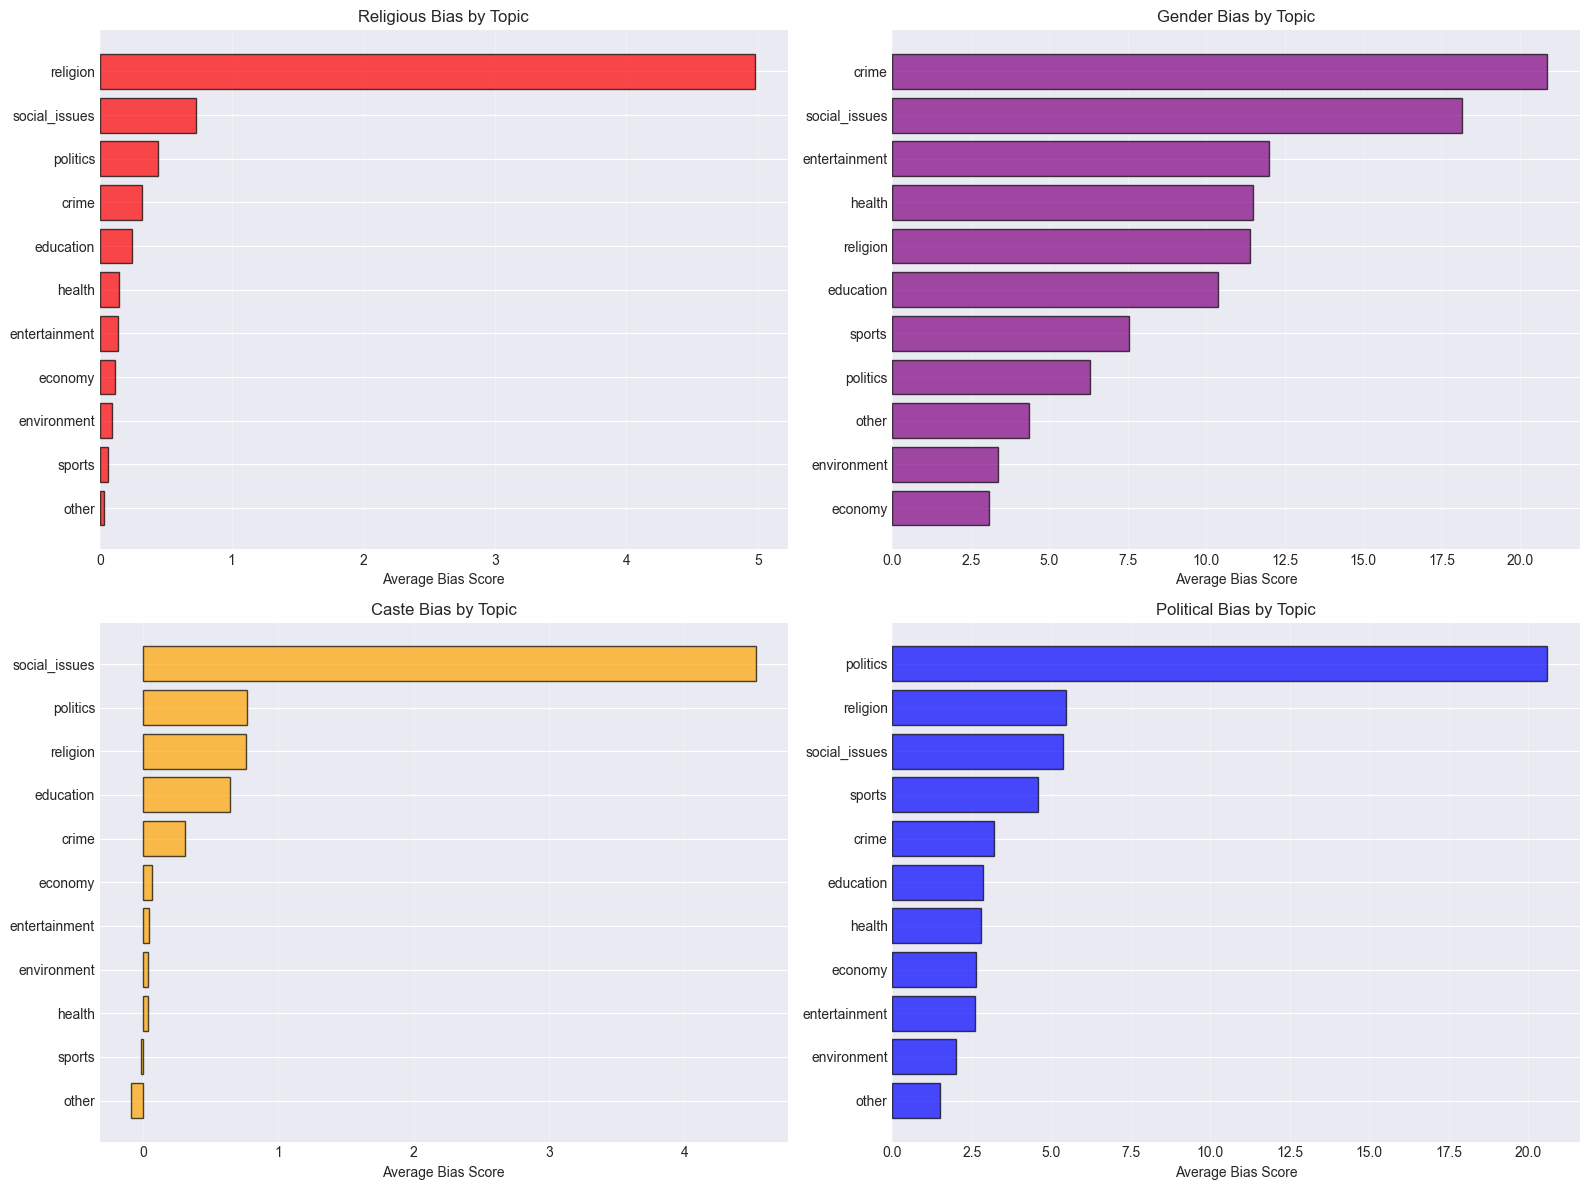

In [ ]:
# Bar charts for each bias dimension
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

bias_dims = [
    ('religious_bias_score', 'Religious Bias', 'red'),
    ('gender_bias_score', 'Gender Bias', 'purple'),
    ('caste_bias_score', 'Caste Bias', 'orange'),
    ('political_bias_score', 'Political Bias', 'blue')
]

for idx, (bias_col, title, color) in enumerate(bias_dims):
    topic_means = df.groupby('topic')[bias_col].mean().sort_values(ascending=False)

    axes[idx].barh(range(len(topic_means)), topic_means.values,
                   color=color, alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(topic_means)))
    axes[idx].set_yticklabels(topic_means.index)
    axes[idx].set_xlabel('Average Bias Score')
    axes[idx].set_title(f'{title} by Topic')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

#### Key insights: Bias scores by topic and dimension

1) Bias is highly concentrated by topic: Religious bias is overwhelmingly in religion, gender bias peaks in crime and social_issues, caste bias is dominated by social_issues, and political bias is strongest in politics (with secondary peaks in religion and social_issues).

2) Most other topics show comparatively low bias: Economy, environment, sports, and “other” have much smaller scores across all dimensions, indicating that strong bias is focused in a few specific topical areas rather than evenly spread.


 ## 5. Topic-Demographic Correlations

In [ ]:
print("\n=== TOPIC-DEMOGRAPHIC CORRELATIONS ===")

# Analyze which demographics are most discussed in each topic
DEMOGRAPHIC_KEYWORDS = {
    'muslim': r'\b(muslim|islamic|islam)\b',
    'hindu': r'\b(hindu|hindutva)\b',
    'women': r'\b(women|woman|female|girl)\b',
    'dalit': r'\b(dalit|sc|scheduled caste)\b',
    'youth': r'\b(youth|young|student|teenager)\b',
    'rural': r'\b(rural|village|farmer)\b',
    'poor': r'\b(poor|poverty|slum)\b'
}


for demo_name, demo_pattern in DEMOGRAPHIC_KEYWORDS.items():
    df[f'mentions_{demo_name}'] = df['text'].apply(
        lambda x: len(re.findall(demo_pattern, x.lower())) if x else 0
    )


=== TOPIC-DEMOGRAPHIC CORRELATIONS ===


In [ ]:
# Demographic mentions by topic
demographic_cols = [c for c in df.columns if c.startswith('mentions_')]

demo_by_topic = df.groupby('topic')[demographic_cols].sum()
demo_by_topic.columns = [c.replace('mentions_', '') for c in demo_by_topic.columns]

print("\n=== DEMOGRAPHIC MENTIONS BY TOPIC ===")
print(demo_by_topic)


=== DEMOGRAPHIC MENTIONS BY TOPIC ===
               muslim  hindu  women  dalit  youth  rural  poor
topic                                                         
crime             256     31   2029    119    490    841    60
economy            63     72    517     75    300    510   391
education          99     41    624    104    933    296   126
entertainment      49     25    773     21    327    212    84
environment         1      4     32     15     32    101    61
health             25     18    583     14    191    342   147
other               3      0     12      0      8     11     5
politics         1076    672   1912    558   1108   1736   979
religion          656    407    195     22    103    139    53
social_issues     116     26    623    176    138    157    63
sports            121     51   1974     68   1263    296   416


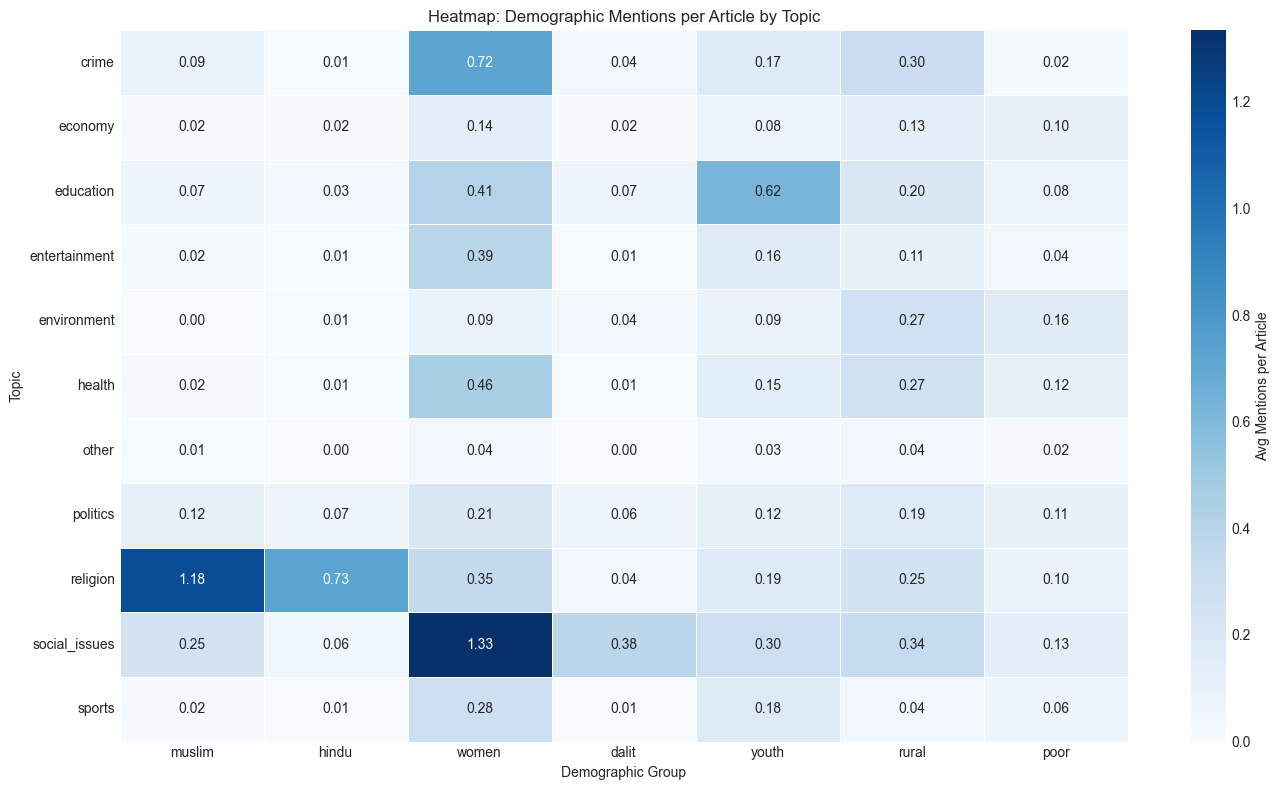

In [ ]:
# Normalize by article count
demo_by_topic_normalized = demo_by_topic.div(df.groupby('topic').size(), axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(demo_by_topic_normalized, annot=True, fmt='.2f', cmap='Blues',
            linewidths=0.5, cbar_kws={'label': 'Avg Mentions per Article'})
plt.xlabel('Demographic Group')
plt.ylabel('Topic')
plt.title('Heatmap: Demographic Mentions per Article by Topic')
plt.tight_layout()
plt.show()

#### Key insights: Demographic mentions per article by topic

1) Religion and social_issues dominate specific group mentions: Religion articles disproportionately mention muslims and hindus, while social_issues articles have the highest overall mentions of women, dalits, and rural groups.

2) Gender and youth visibility varies by topic: Women are frequently referenced in crime, social_issues, health, and education, and youth mentions are notably higher in education and social_issues compared to other topics.

 ## 8. Summary Report

1. Topics with Highest Bias:
   1. 'social_issues' has highest average bias (28.76)
   2. 'politics' has highest average bias (28.12)
   3. 'crime' has highest average bias (24.68)

2. Dominant Bias Dimensions by Topic:
   - 'Social Issues': Dominated by Gender bias (18.15)
   - 'Politics': Dominated by Political bias (20.60)
   - 'Crime': Dominated by Gender bias (20.87)

3. Topic-Demographic Patterns:
   - 'Religion' articles most frequently mention 'muslim' (656 total)
   - 'Social Issues' articles most frequently mention 'women' (623 total)
   - 'Politics' articles most frequently mention 'women' (1912 total)

4. Temporal Patterns:
   - Overall bias is decreasing over time (-2.6% change)